In [2]:
# Standard Libraries
import os, time, glob
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter



# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


Device: cuda


In [3]:
# ---- Load dataset ----
base_dir = "/kaggle/input/coffee-beans-saad"

def create_dataframe(data_dir):
    file_paths, labels = [], []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir): continue
        for img_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_name)
    df = pd.DataFrame({"file_path": file_paths, "label": labels})
    return df.sample(frac=1).reset_index(drop=True)  # shuffle

train_df = create_dataframe(os.path.join(base_dir, "train"))
test_df = create_dataframe(os.path.join(base_dir, "test"))
print("Train samples:", len(train_df), "Test samples:", len(test_df))

# Label mapping
label_to_idx = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}
idx_to_label = {v:k for k,v in label_to_idx.items()}
num_classes = len(label_to_idx)

# Dataset class
class CoffeeBeanDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.df.iloc[idx]['file_path']).convert("RGB")
        label = label_to_idx[self.df.iloc[idx]['label']]
        if self.transform: img = self.transform(img)
        return img, label

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# Datasets and loaders
train_dataset = CoffeeBeanDataset(train_df, transform=train_transforms)
test_dataset = CoffeeBeanDataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train samples: 1200 Test samples: 400


In [4]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*14*14,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model
model = CustomCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [5]:
num_epochs = 10
train_loss_history, train_acc_history = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0, 0
    total = 0
    start = time.time()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*imgs.size(0)
        _, preds = torch.max(outputs,1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss/total
    epoch_acc = correct/total
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f} | Time: {time.time()-start:.2f}s")


Epoch 1/10 | Loss: 0.8477 | Accuracy: 0.7108 | Time: 17.87s
Epoch 2/10 | Loss: 0.1495 | Accuracy: 0.9517 | Time: 5.35s
Epoch 3/10 | Loss: 0.0870 | Accuracy: 0.9700 | Time: 5.34s
Epoch 4/10 | Loss: 0.0960 | Accuracy: 0.9658 | Time: 5.50s
Epoch 5/10 | Loss: 0.1439 | Accuracy: 0.9533 | Time: 5.42s
Epoch 6/10 | Loss: 0.0594 | Accuracy: 0.9767 | Time: 5.39s
Epoch 7/10 | Loss: 0.0615 | Accuracy: 0.9783 | Time: 5.42s
Epoch 8/10 | Loss: 0.0630 | Accuracy: 0.9783 | Time: 5.40s
Epoch 9/10 | Loss: 0.0893 | Accuracy: 0.9642 | Time: 5.38s
Epoch 10/10 | Loss: 0.0510 | Accuracy: 0.9842 | Time: 5.31s


In [6]:
# Use only the CNN features (remove classifier)
feature_extractor = model.features.to(device)
feature_extractor.eval()

def extract_features(loader):
    features_list, labels_list = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            feats = feature_extractor(imgs)  # output: [batch, 256, 14, 14]
            feats = feats.view(feats.size(0), -1).cpu().numpy()  # flatten to [batch, 256*14*14]
            features_list.append(feats)
            labels_list.append(lbls.numpy())
    X = np.vstack(features_list)
    y = np.hstack(labels_list)
    return X, y

X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(test_loader)

print("Feature shape:", X_train.shape)  # Should be [num_samples, 50176]


Feature shape: (1200, 50176)


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
start_train = time.time()
knn.fit(X_train, y_train)
end_train = time.time()

print(f"Training Time: {end_train - start_train:.2f} seconds")

# Predict
start_test = time.time()
y_pred = knn.predict(X_test)
end_test = time.time()
print(f"Testing Time: {end_test - start_test:.2f} seconds")

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Training Time: 0.03 seconds
Testing Time: 1.30 seconds
Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       0.98      0.98      0.98       100

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

Confusion Matrix:
 [[ 98   0   0   2]
 [  0 100   0   0]
 [  0   0 100   0]
 [  2   0   0  98]]


Overall Accuracy: 0.9900

Classification Report:
               precision    recall  f1-score   support

           0     0.9800    0.9800    0.9800       100
           1     1.0000    1.0000    1.0000       100
           2     1.0000    1.0000    1.0000       100
           3     0.9800    0.9800    0.9800       100

    accuracy                         0.9900       400
   macro avg     0.9900    0.9900    0.9900       400
weighted avg     0.9900    0.9900    0.9900       400


Confusion Matrix:
 [[ 98   0   0   2]
 [  0 100   0   0]
 [  0   0 100   0]
 [  2   0   0  98]]


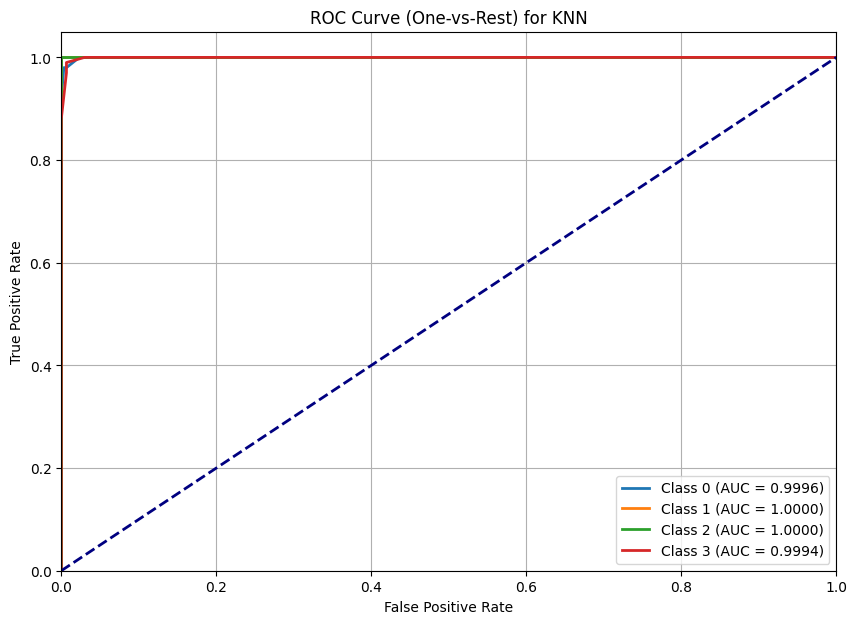


Training Time: 0.03 sec
Testing Time: 1.29 sec


In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import time
import numpy as np

# --- Train KNN and measure training time ---
start_train = time.time()
knn.fit(X_train, y_train)
end_train = time.time()
train_time = end_train - start_train

# --- Test KNN and measure testing time ---
start_test = time.time()
y_pred = knn.predict(X_test)
end_test = time.time()
test_time = end_test - start_test

# --- Accuracy ---
overall_acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {overall_acc:.4f}")

# --- Classification Report ---
report = classification_report(y_test, y_pred, digits=4)
print("\nClassification Report:\n", report)

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# --- ROC & AUC (multiclass) ---
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_prob = knn.predict_proba(X_test)

plt.figure(figsize=(10, 7))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest) for KNN")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Print training and testing time ---
print(f"\nTraining Time: {train_time:.2f} sec")
print(f"Testing Time: {test_time:.2f} sec")



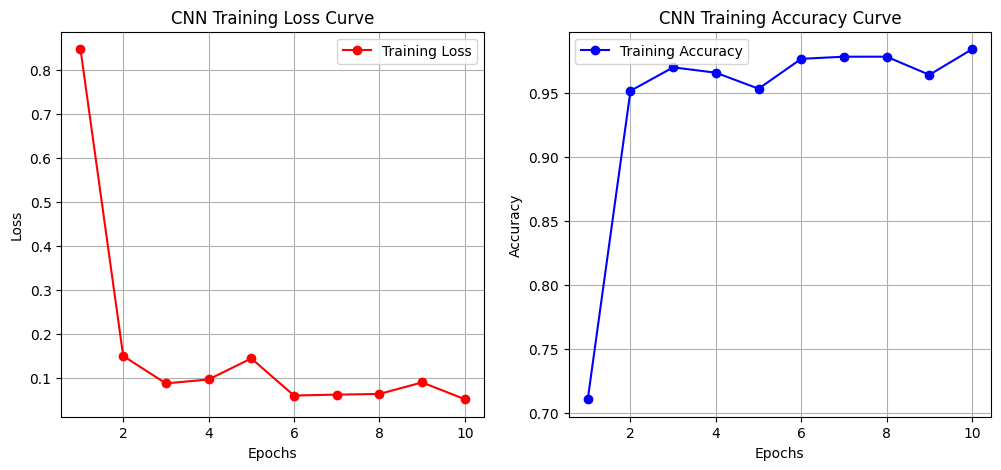


CNN Training ran for 10 epochs
KNN Training Time: 0.03 sec
KNN Testing Time: 1.29 sec

KNN Accuracy: 0.9900

Classification Report:
               precision    recall  f1-score   support

           0     0.9800    0.9800    0.9800       100
           1     1.0000    1.0000    1.0000       100
           2     1.0000    1.0000    1.0000       100
           3     0.9800    0.9800    0.9800       100

    accuracy                         0.9900       400
   macro avg     0.9900    0.9900    0.9900       400
weighted avg     0.9900    0.9900    0.9900       400


Confusion Matrix:
 [[ 98   0   0   2]
 [  0 100   0   0]
 [  0   0 100   0]
 [  2   0   0  98]]


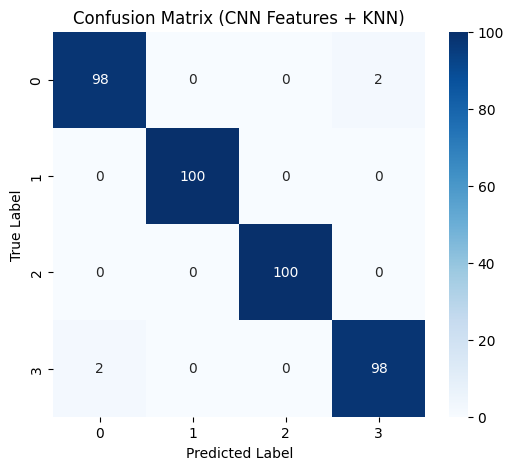

In [10]:
# --- Plot CNN Learning and Loss Curves ---
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_loss_history, marker='o', color='red', label='Training Loss')
plt.title("CNN Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_acc_history, marker='o', color='blue', label='Training Accuracy')
plt.title("CNN Training Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.show()

# --- Report Training and Testing Time ---
print(f"\nCNN Training ran for {num_epochs} epochs")
print(f"KNN Training Time: {end_train - start_train:.2f} sec")
print(f"KNN Testing Time: {end_test - start_test:.2f} sec")

# --- Final Metrics ---
print(f"\nKNN Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:\n", cm)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (CNN Features + KNN)")
plt.show()
